# Trabalho 8


## 1) Uma abordagem muito utilizada para a escolha do valor de k, em métodos de agrupamento como o KMeans, é o método do cotovelo. Pesquise e explique como esse método funciona.

O algoritmo k-means precisa que você defina previamente o número de agrupamentos (clusters) que ele deve encontrar nos dados. O problema é que, na maioria das vezes, não sabemos qual é esse número ideal. A solução é utilizar o Método do Cotovelo, que é uma técnica usada para encontrar o número ótimo de clusters. A ideia principal é executar o k-means várias vezes, com um número diferente de clusters em cada execução, e depois avaliar qual dessas execuções oferece o melhor equilíbrio. O objetivo disso é atingir um ponto onde:

- Os dados dentro de um mesmo cluster sejam o mais parecidos possível (homogêneos).
- Os diferentes clusters sejam o mais distintos possível uns dos outros.

#### Como Funciona na Prática:

1. Primeiro precisamos cálcular a Soma dos Quadrados Intra-clusters (WCSS): Para cada execução do k-means com um número 'k' de clusters, calcula-se uma métrica chamada WCSS (within-clusters sum-of-squares). Essa métrica, que a biblioteca scikit-learn chama de inertia_, mede a soma das distâncias ao quadrado de cada ponto de dado até o centro do seu próprio cluster. Um WCSS baixo indica que os pontos estão bem agrupados e próximos de seus centros, o que é bom.
2. Criação do Gráfico de Cotovelo: Cria-se um gráfico de linha onde o eixo X representa o número de clusters (k) e o eixo Y representa o valor do WCSS correspondente.
3. Para identificar o ponto exato da quantidade ótima de clusters do cotovelo de forma precisa e matemática, o processo é o seguinte:

  - Trace uma Reta de Referência: Primeiro, trace uma linha reta ligando o ponto do primeiro resultado (ex: para 2 clusters) ao do último resultado (ex: para 20 clusters). Essa linha representa a tendência geral de redução do erro.

  - Meça as Distâncias: Para cada um dos outros pontos do gráfico, calcule sua distância perpendicular até essa reta de referência.

  - Encontre o Ponto de Distância Máxima: O "cotovelo" é definido como o ponto que possui a maior distância em relação à reta. Ele é o ponto que mais se desvia da tendência geral, marcando a mudança mais brusca na taxa de redução do erro.

  - O número de clusters correspondente a esse ponto de distância máxima.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
# Dataset com países, PIB, expectativa de vida e população
url = 'https://raw.githubusercontent.com/plotly/datasets/master/gapminderDataFiveYear.csv'
df = pd.read_csv(url)

# Filtra apenas dados da Europa e América no ano mais recente (2007)
# Corrected filtering using.isin()
df_euro = df[(df['continent'].isin(['Europe', 'Americas'])) & (df['year'] == 2007) ].copy()
df_euro.reset_index(drop=True, inplace=True)

# Seleção de variáveis
features = ['gdpPercap', 'lifeExp', 'pop']
countries = df_euro['country'].values
X = df_euro[features].values


In [ ]:
# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

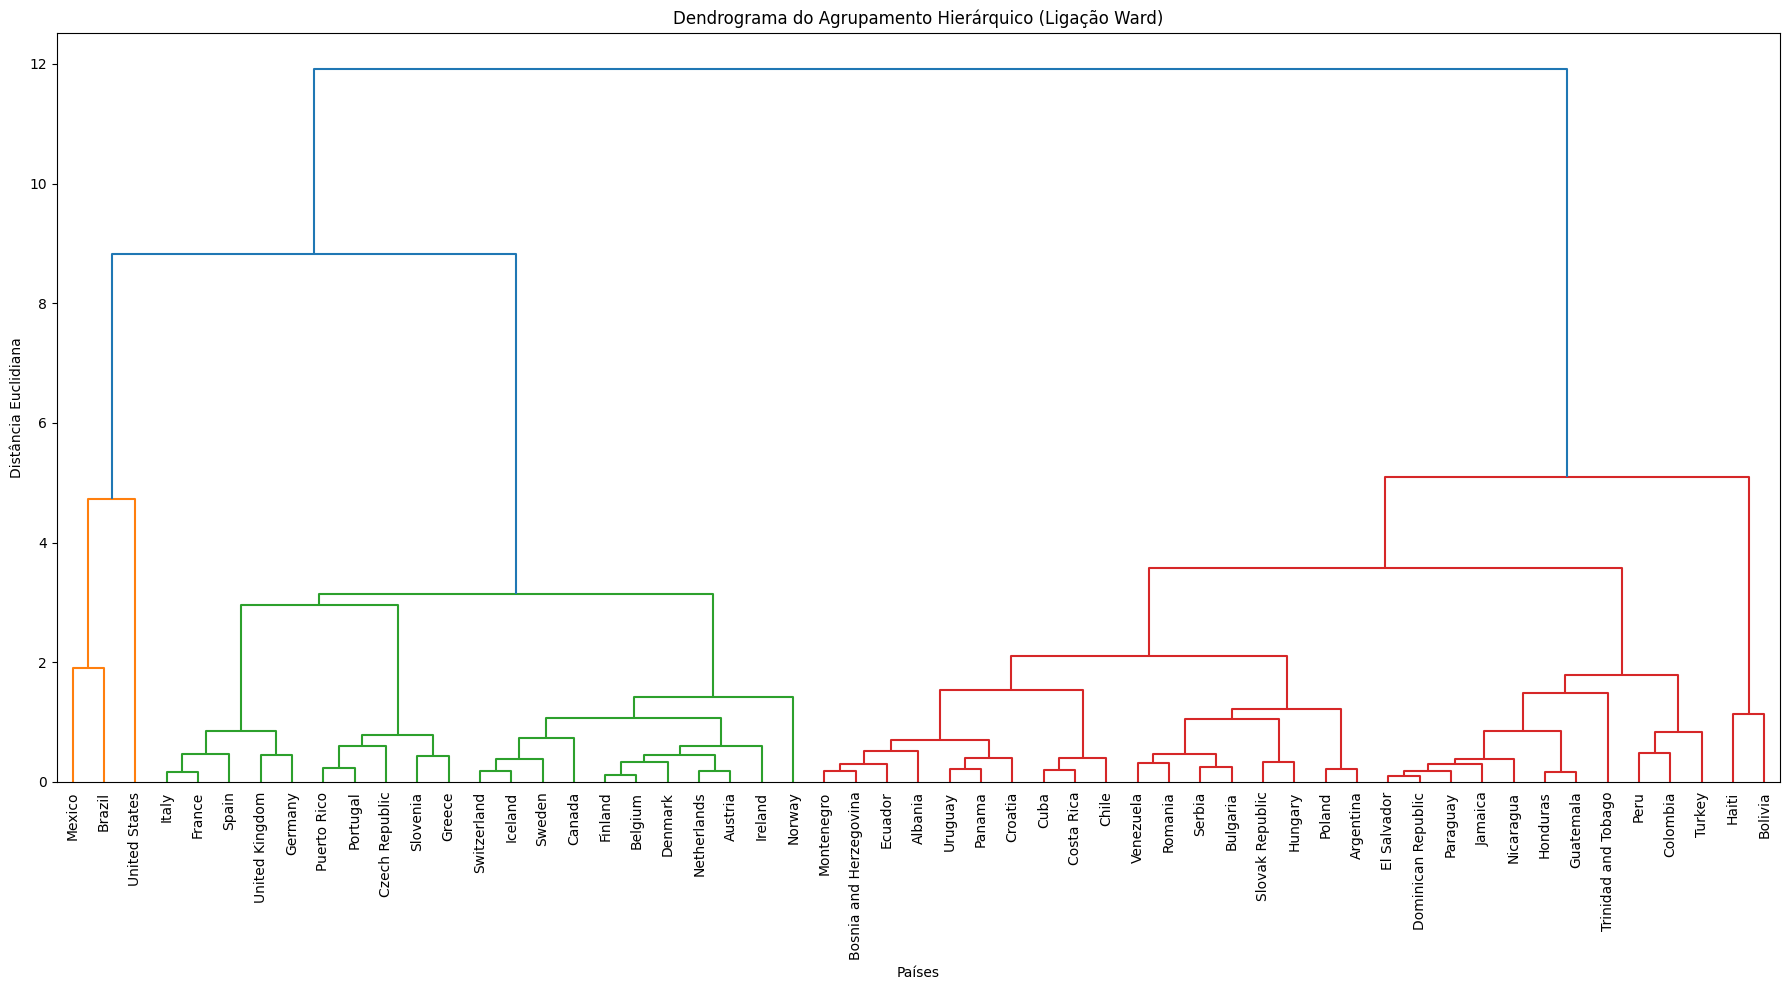

In [ ]:
# Agrupamento Hierárquico e Dendrograma
plt.figure(figsize=(18, 10))
plt.title('Dendrograma do Agrupamento Hierárquico (Ligação Ward)')
plt.xlabel('Países')
plt.ylabel('Distância Euclidiana')
linked = linkage(X_scaled, method='ward')
dendrogram(linked,
            orientation='top',
            labels=countries,
            distance_sort='descending',
            show_leaf_counts=True,
            leaf_rotation=90.,
            leaf_font_size=10.)
plt.tight_layout()
plt.show()

O cálculo automático sugere que o número ótimo de clusters é: 4


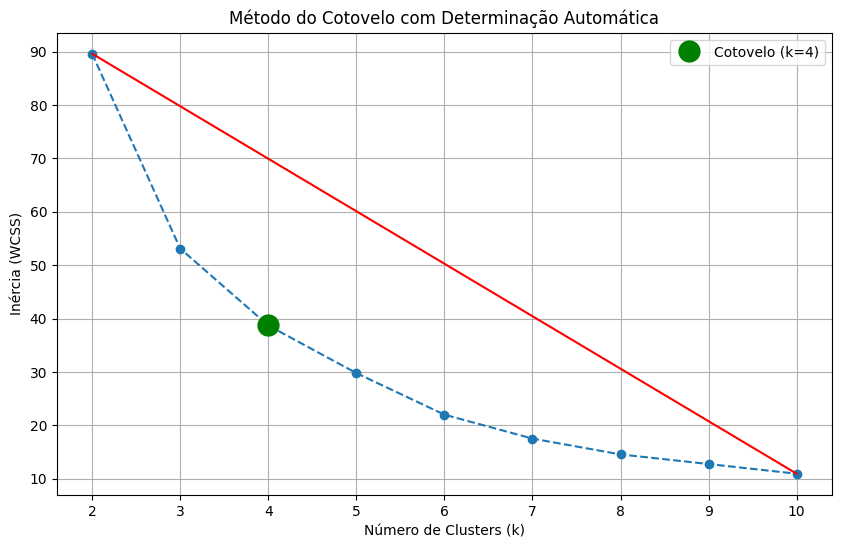

In [ ]:
def calculate_wcss(data):
    """
    Calcula a inércia (Within-Cluster Sum of Squares) para um range de clusters.
    """
    wcss = []
    # Itera de 2 a 10 clusters
    for n in range(2, 11):
        kmeans = KMeans(n_clusters=n, random_state=42, n_init=10)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)
    return wcss

def optimal_number_of_clusters(wcss):
    """
    Calcula o número ótimo de clusters encontrando o ponto mais distante
    de uma linha reta entre o primeiro e o último valor de WCSS.
    """
    x1, y1 = 2, wcss[0]
    x2, y2 = 10, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i + 2
        y0 = wcss[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator / denominator)

    # O número ótimo de clusters é o índice de maior distância + 2 (porque o range começa em 2)
    return distances.index(max(distances)) + 2

sum_of_squares = calculate_wcss(X_scaled)
n_otimo = optimal_number_of_clusters(sum_of_squares)

print(f"O cálculo automático sugere que o número ótimo de clusters é: {n_otimo}")

# Visualização do Método do Cotovelo
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), sum_of_squares, marker='o', linestyle='--')
# Linha entre o primeiro e último ponto
plt.plot([2, 10], [sum_of_squares[0], sum_of_squares[-1]], 'r-')
# Ponto do "cotovelo" calculado
plt.plot(n_otimo, sum_of_squares[n_otimo-2], 'go', markersize=15, label=f'Cotovelo (k={n_otimo})')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia (WCSS)')
plt.title('Método do Cotovelo com Determinação Automática')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Aplicação do KMeans com o k ótimo calculado
kmeans = KMeans(n_clusters=n_otimo, random_state=42, n_init=10)
df_euro['cluster'] = kmeans.fit_predict(X_scaled)

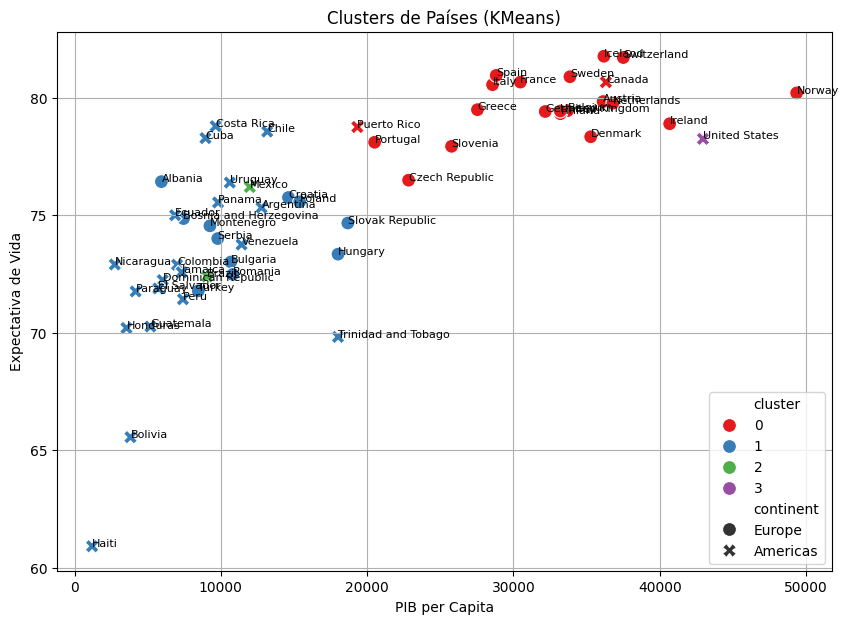

In [ ]:
# KMeans com o valor ótimo
kmeans = KMeans(n_clusters=n_otimo, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df_euro['cluster'] = labels

# Plotagem dos clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_euro, x='gdpPercap', y='lifeExp', hue='cluster', palette='Set1', style='continent', s=100)

for i, row in df_euro.iterrows():
    plt.text(row['gdpPercap'], row['lifeExp'], row['country'], fontsize=8)

plt.title('Clusters de Países (KMeans)')
plt.xlabel('PIB per Capita')
plt.ylabel('Expectativa de Vida')
plt.legend()
plt.grid(True)
plt.show()




Cluster 0:
['Austria' 'Belgium' 'Canada' 'Czech Republic' 'Denmark' 'Finland'
 'France' 'Germany' 'Greece' 'Iceland' 'Ireland' 'Italy' 'Netherlands'
 'Norway' 'Portugal' 'Puerto Rico' 'Slovenia' 'Spain' 'Sweden'
 'Switzerland' 'United Kingdom']

Cluster 1:
['Albania' 'Argentina' 'Bolivia' 'Bosnia and Herzegovina' 'Bulgaria'
 'Chile' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Dominican Republic'
 'Ecuador' 'El Salvador' 'Guatemala' 'Haiti' 'Honduras' 'Hungary'
 'Jamaica' 'Montenegro' 'Nicaragua' 'Panama' 'Paraguay' 'Peru' 'Poland'
 'Romania' 'Serbia' 'Slovak Republic' 'Trinidad and Tobago' 'Turkey'
 'Uruguay' 'Venezuela']

Cluster 2:
['Brazil' 'Mexico']

Cluster 3:
['United States']


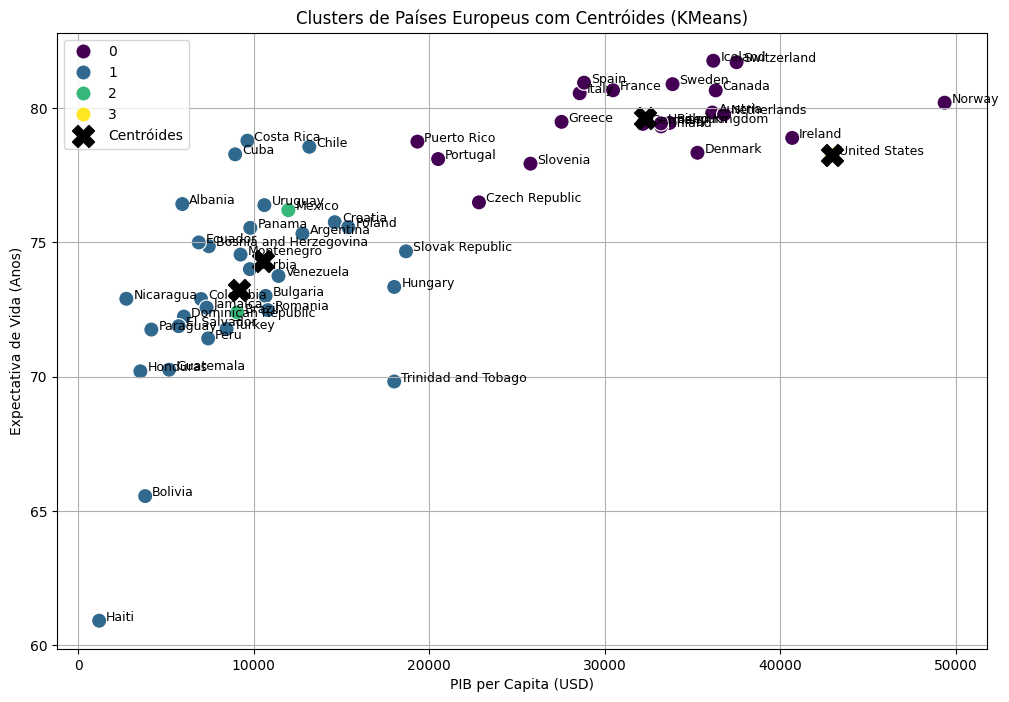

In [ ]:
# Mostrar países por cluster
for c in sorted(df_euro['cluster'].unique()):
    print(f"\nCluster {c}:")
    print(df_euro[df_euro['cluster'] == c]['country'].values)

centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Plotagem dos Clusters e Centróides
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_euro, x='gdpPercap', y='lifeExp', hue='cluster',
                palette='viridis', s=120)

plt.scatter(x=centroids_original[:, 0], y=centroids_original[:, 1],
            marker='X', s=250, c='black', label='Centróides')

# Adiciona o nome dos países
for i, row in df_euro.iterrows():
    plt.text(row['gdpPercap'] + 400, row['lifeExp'], row['country'], fontsize=9)

# Detalhes do gráfico
plt.title('Clusters de Países Europeus com Centróides (KMeans)')
plt.xlabel('PIB per Capita (USD)')
plt.ylabel('Expectativa de Vida (Anos)')
plt.legend()
plt.grid(True)
plt.show()


### (a) Qual a importância da normalização neste contexto?
A normalização é essencial porque as variáveis analisadas (PIB per capita, expectativa de vida e população) possuem escalas muito diferentes. Por exemplo, a população pode variar em milhões, enquanto a expectativa de vida varia entre 50 e 85 anos. Sem normalização, as variáveis com maior escala dominariam a métrica de distância, distorcendo os agrupamentos. A normalização garante que todas as variáveis contribuam igualmente no cálculo de similaridade entre os países.

### (b) Que tipo de estrutura o dendrograma revelou? Quantos grupos são sugeridos visualmente?
O dendrograma revelou uma estrutura hierárquica com diferentes níveis de agrupamento. Ao cortar o gráfico por volta da altura 7, observam-se 3 grandes grupos distintos antes da fusão entre ramos se tornar mais próxima. Portanto, o dendrograma sugere que uma divisão em **3 grupos** é apropriada para os dados analisados.

### (c) O que representa a “inércia” no método do cotovelo? Qual valor de k foi escolhido e por quê?
A inércia, também conhecida como WCSS (Within-Cluster Sum of Squares), representa a soma das distâncias quadradas entre os pontos e o centróide de seus respectivos clusters. Quanto menor a inércia, mais compactos são os clusters. Usando o método do cotovelo com cálculo geométrico automático, o valor ótimo de **k escolhido foi 4**, pois é o ponto que possui a maior distância em relação à reta. Ele é o ponto que mais se desvia da tendência geral, marcando a mudança mais brusca na taxa de redução do erro.

### (d) Ao observar o gráfico com os clusters do KMeans, que padrões podem ser percebidos entre os países? Os agrupamentos parecem coerentes?
Sim, os agrupamentos fazem sentido. Países com **alto PIB per capita** e **alta expectativa de vida** formam um cluster (em geral países da Europa Ocidental e América do Norte). Já países com **baixo PIB** e **expectativa de vida mais baixa** formam outro grupo, normalmente da América Central e América do Sul. Há ainda um grupo intermediário com características particulares. Os agrupamentos são coerentes com padrões de desenvolvimento econômico.

### (e) Escolha dois clusters distintos e interprete suas características principais com base nas variáveis analisadas.
- Cluster 0: Este grupo é formado por países da Europa Ocidental e Canadá. O padrão aqui é claro: são nações com PIB per capita e expectativa de vida muito altos. Eles formam um bloco coeso de economias avançadas e com alto bem-estar social.
- Cluster 1: Este é o cluster mais numeroso e heterogêneo. Inclui a maioria dos países da América Latina e nações do Leste Europeu. O padrão que os une é um nível de desenvolvimento socioeconômico intermediário ou em transição, com indicadores de PIB e expectativa de vida inferiores aos do Cluster 0.
- Cluster 2: O agrupamento de Brasil e México em um cluster separado é significativo. O padrão aqui é a população. Embora seus indicadores de PIB e expectativa de vida possam ser semelhantes aos de outros países do Cluster 1 (como Argentina ou Chile), suas populações massivas os tornam demograficamente distintos, e o algoritmo os isolou por isso.
- Cluster 3: Os Estados Unidos formam um cluster próprio. O padrão é sua combinação única de ter um PIB per capita extremamente alto (característica do Cluster 0) e ao mesmo tempo, uma população muito grande (característica que o diferencia do Cluster 0 e também do Cluster 2). Esse perfil, que une alta riqueza e alta população, não tem iguais no restante da amostra.

### (f) Cite uma vantagem e uma limitação do uso do KMeans neste tipo de análise.
- **Vantagem:** O KMeans é eficiente, fácil de interpretar e rápido mesmo com conjuntos de dados relativamente grandes. É útil quando os clusters são aproximadamente esféricos.
- **Limitação:** O KMeans exige que o número de clusters seja definido previamente (necessitando métodos como o cotovelo) e não lida bem com clusters de formas ou tamanhos muito diferentes. Também é sensível a outliers.